<a href="https://colab.research.google.com/github/Jaesu26/dacon-species-classification-using-snp/blob/main/2023-01-16-%EC%9C%A0%EC%A0%84%EC%B2%B4%EC%A0%95%EB%B3%B4-%ED%92%88%EC%A2%85-%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 유전체 정보 품종 분류 AI 경진대회

In [1]:
!pip install xgboost==1.7.2
!pip install lightgbm==2.2.3
!pip install catboost==1.1.1
!pip install scikit-learn==1.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 5.4 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 데이터 불러오기

In [76]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import random
import os

from abc import ABC, abstractmethod
from typing import List, Tuple, Any, Literal
from numpy.typing import NDArray
from dataclasses import dataclass
from tqdm.auto import tqdm

warnings.filterwarnings('ignore') 

In [3]:
import google.colab

google.colab.drive.mount('/content/drive')  # 코랩과 구글드라이브 연결

Mounted at /content/drive


In [4]:
%cd  /content/drive/MyDrive/Colab Notebooks/유전체정보-품종-분류

/content/drive/MyDrive/Colab Notebooks/유전체정보-품종-분류


- 데이터 불러오기

In [5]:
train_path = './data/train.csv'
test_path = './data/test.csv'
submission_path = './data/sample_submission.csv'

In [6]:
df = pd.read_csv(train_path)
test = pd.read_csv(test_path)
submission = pd.read_csv(submission_path)

In [7]:
df['trait'] = df['trait'].map({1:0, 2:1})
test['trait'] = test['trait'].map({1:0, 2:1})

- 무의미한 변수 제거

In [8]:
df = df.drop(['id', 'father', 'mother', 'gender'], axis=1)
test = test.drop(['id', 'father', 'mother', 'gender'], axis=1)

## 시각화

`-` SNP 정보는 `AA`, `AC`, `AG`, `CC`, `GG` 총 5가지 경우가 존재

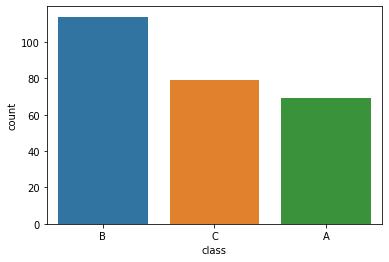

In [10]:
sns.countplot(df['class'])

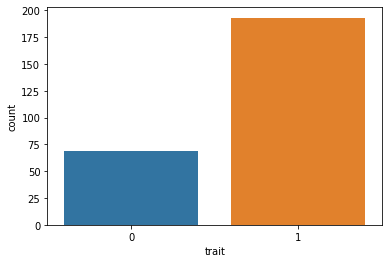

In [11]:
sns.countplot(df['trait'])

`-` `trait`이 1이면 `A`이다

## 훈련

In [9]:
from scipy import stats
from imblearn.over_sampling import SMOTEN

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import LinearSVC

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [10]:
def seed_everything(seed: int = 23) -> None:
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

- 전처리

In [11]:
df['class'] = df['class'].map({'A':0, 'B':1, 'C':2})

In [12]:
target = df.pop('class')

- 라벨 인코딩, 원핫 인코딩

In [13]:
def label_encoding(train_data: pd.DataFrame, test_data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train_data, test_data = train_data.copy(), test_data.copy()
    categorical_columns = train_data.columns[train_data.dtypes == 'object']
    label_encoder = LabelEncoder()

    for col in categorical_columns:
        train_data[col] = label_encoder.fit_transform(train_data[col])
        test_data[col] = label_encoder.transform(test_data[col])
        
    return train_data, test_data

In [14]:
def onehot_encoding(train_data: pd.DataFrame, test_data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train_data, test_data = train_data.copy(), test_data.copy()
    categorical_columns = train_data.columns[train_data.dtypes == 'object']
    onehot_encoder = OneHotEncoder(sparse=False)
    
    for col in categorical_columns:
        onehot_encoder.fit(train_data[[col]])
        columns = col + onehot_encoder.categories_[0]
        train_data = pd.concat([train_data, pd.DataFrame(onehot_encoder.transform(train_data[[col]]), columns=columns)], axis=1)
        test_data = pd.concat([test_data, pd.DataFrame(onehot_encoder.transform(test_data[[col]]), columns=columns)], axis=1)

    train_data = train_data.drop(categorical_columns, axis=1)
    test_data = test_data.drop(categorical_columns, axis=1)
    return train_data, test_data

In [75]:
def encoding(
    train_data: pd.DataFrame, 
    test_data: pd.DataFrame, 
    encoding_type: Literal['label', 'onehot']
) -> Tuple[pd.DataFrame,  pd.DataFrame]:
    func_mapping = {'label':label_encoding, 'onehot':onehot_encoding}
    assert encoding_type in func_mapping

    return func_mapping[encoding_type](train_data, test_data)

- 함수 정의

`-` ref: https://github.com/Lightning-AI/lightning/blob/master/examples/pl_loops/kfold.py

In [16]:
@dataclass
class KFoldDataset:
    X: pd.DataFrame
    y: pd.Series
    X_predict: pd.DataFrame
    encoding_type: Literal['label', 'onehot'] = 'onehot'
    oversampling: bool = False
    seed: int = 23

    def setup(self) -> None:
        self.X, self.X_predict = encoding(self.X, self.X_predict, self.encoding_type)

    def setup_folds(self, num_folds: int) -> None:
        kfold = StratifiedKFold(num_folds, shuffle=True, random_state=self.seed)
        self.splits = [split for split in kfold.split(self.X, self.y)]

    def setup_fold_index(self, fold_index: int) -> None:
        train_indices, val_indices = self.splits[fold_index]
        self.X_train, self.y_train = self.X.iloc[train_indices], self.y.iloc[train_indices]
        self.X_val, self.y_val = self.X.iloc[val_indices], self.y.iloc[val_indices]

    def setup_fold_end(self) -> None:
        if self.oversampling:
            smote = SMOTEN(random_state=self.seed)
            self.X_train, self.y_train = smote.fit_resample(self.X_train, self.y_train)

    def train_data(self) -> Tuple[pd.DataFrame, pd.Series]:
        return self.X_train, self.y_train

    def val_data(self) -> Tuple[pd.DataFrame, pd.Series]:
        return self.X_val, self.y_val

    def predict_data(self) -> pd.DataFrame:
        return self.X_predict

In [17]:
@dataclass
class SklearnModel(ABC):
    def __post_init__(self) -> None:
        self.model = self.init_model()

    @abstractmethod
    def init_model(self) -> Any:
        pass 

    def training_step(self, train_data: Any, val_data: Any) -> None:
        X_train, y_train = train_data
        self.model.fit(X_train, y_train)

    def validation_step(self, val_data: Any) -> float:
        X_val, y_val = val_data
        eval_result = f1_score(y_val, self.model.predict(X_val), average='macro')
        print(f'Best Macro F1 : {eval_result:.4f}', end='\n'*2)
        return eval_result

    def predict_step(self, predict_data: Any) -> NDArray[Any]:
        X_predict = predict_data
        pred = self.model.predict(X_predict)
        return pred

In [18]:
@dataclass
class KFoldLoop:
    num_folds: int

    @property
    def done(self) -> bool:
        return self.current_fold >= self.num_folds

    def on_run_start(self) -> None:
        self.current_fold = 0
        self.trainer.dataset.setup()
        self.trainer.dataset.setup_folds(self.num_folds)

    def on_advance_start(self) -> None:
        self.trainer.dataset.setup_fold_index(self.current_fold)
        self.trainer.dataset.setup_fold_end()
        print(f'[{self.current_fold + 1} / {self.num_folds}] Fold Training......')

    def advance(self) -> None:
        train_data, val_data = self.trainer.dataset.train_data(), self.trainer.dataset.val_data()
        predict_data = self.trainer.dataset.predict_data()
        self.trainer.model.training_step(train_data, val_data)
        eval_result = self.trainer.model.validation_step(val_data)
        self.trainer.best_scores.append(eval_result)
        pred = self.trainer.model.predict_step(predict_data)
        self.trainer.preds.append(pred)

    def on_advance_end(self) -> None:
        self.current_fold += 1

    def on_run_end(self) -> None:
        print(f'{self.num_folds} Fold Mean Macro F1 : {np.mean(self.trainer.best_scores):.4f}', end='\n'*2)

    def run(self) -> None:
        self.on_run_start()
        while not self.done:
            self.on_advance_start()
            self.advance()
            self.on_advance_end()
        self.on_run_end()

In [19]:
@dataclass
class Trainer:
    num_folds: int = 5

    def cross_val_predict(self, model: Any, dataset: KFoldDataset) -> List[NDArray[Any]]:
        self.fit_loop = KFoldLoop(self.num_folds)
        self.fit_loop.trainer = self
        self.model, self.dataset = model, dataset
        self.best_scores, self.preds = [], []
        self.fit_loop.run()
        return self.preds

`-` seed에 따라 다르다

`-` 오버샘플링 유무에 따라 다르다

`-` 인코딩 타입에 따라 다르다

In [20]:
def seed_ensemble(
    trainer: Trainer, 
    model: Any, 
    dataset: KFoldDataset, 
    seeds: List[int]
) -> Tuple[NDArray[np.float], NDArray[Any]]:
    preds = []
    best_scores = []
    for seed in seeds:
        print(f'########## Seed Number {seed} ##########', end='\n'*2)
        seed_everything(seed)
        dataset.seed = seed
        pred = trainer.cross_val_predict(model, dataset)
        preds.append(np.stack(pred, axis=-1))
        best_scores.extend(trainer.best_scores)

    google.colab.output.clear()
    print(f'Seed Ensemble Output -> Mean: {np.mean(best_scores):.4f}  Std: {np.std(best_scores, ddof=1):.4f}')
    return best_scores, np.concatenate(preds, axis=-1)

In [96]:
def compare_preprocessing(
    trainer: Trainer, 
    model: Any, 
    X: pd.DataFrame, 
    y: pd.Series, 
    seeds: List[int]
) -> None:
    results = {}
    for encoding_type in ['label', 'onehot']:
        for oversampling in [False, True]:
            print(f'Start {encoding_type} encoding and {oversampling} oversamping', end='\n'*2)
            dataset = KFoldDataset(X, y, X, encoding_type, oversampling)
            best_scores, _ = seed_ensemble(trainer, model, dataset, seeds)
            results[f'{encoding_type}-encoding  {oversampling}-oversamping'] = best_scores

    google.colab.output.clear()
    for key, value in results.items():
        print(f'Type: {key:>34}  Mean: {np.mean(value):.4f}, Std: {np.std(value, ddof=1):.4f}')

In [97]:
SEED = 23
seeds = [SEED * n for n in range(30)]
num_folds = 5
trainer = Trainer(num_folds)

### 전처리 비교 

- LinearSVC

In [98]:
class LinearSVCModel(SklearnModel):
    def init_model(self) -> Any: 
        return LinearSVC(C=1.0, random_state=SEED)

In [99]:
linear_svc = LinearSVCModel()

In [25]:
%%time
compare_preprocessing(trainer, linear_svc, df, target, seeds)

Type:  label-encoding  False-oversamping  Mean: 0.9607, Std: 0.0244
Type:   label-encoding  True-oversamping  Mean: 0.9584, Std: 0.0265
Type: onehot-encoding  False-oversamping  Mean: 0.9354, Std: 0.0325
Type:  onehot-encoding  True-oversamping  Mean: 0.9355, Std: 0.0316
CPU times: user 39.7 s, sys: 698 ms, total: 40.4 s
Wall time: 50.4 s


- LogisticRegression

In [26]:
class LogisticModel(SklearnModel):
    def init_model(self) -> Any:
        return LogisticRegression(C=1.0, random_state=SEED)

In [27]:
logistic = LogisticModel()

In [28]:
%%time
compare_preprocessing(trainer, logistic, df, target, seeds)

Type:  label-encoding  False-oversamping  Mean: 0.9606, Std: 0.0235
Type:   label-encoding  True-oversamping  Mean: 0.9572, Std: 0.0248
Type: onehot-encoding  False-oversamping  Mean: 0.9455, Std: 0.0285
Type:  onehot-encoding  True-oversamping  Mean: 0.9480, Std: 0.0280
CPU times: user 47.6 s, sys: 905 ms, total: 48.5 s
Wall time: 50.8 s


- RidgeClassifier

In [29]:
class RidgeModel(SklearnModel):
    def init_model(self) -> Any:
        return RidgeClassifier(alpha=0.1, random_state=SEED)

In [30]:
ridge = RidgeModel()

In [31]:
%%time
compare_preprocessing(trainer, ridge, df, target, seeds)

Type:  label-encoding  False-oversamping  Mean: 0.9574, Std: 0.0241
Type:   label-encoding  True-oversamping  Mean: 0.9554, Std: 0.0237
Type: onehot-encoding  False-oversamping  Mean: 0.9492, Std: 0.0269
Type:  onehot-encoding  True-oversamping  Mean: 0.9518, Std: 0.0252
CPU times: user 31.4 s, sys: 973 ms, total: 32.3 s
Wall time: 32 s


- SGDClassifier

In [32]:
class SGDModel(SklearnModel):
    def init_model(self) -> Any:
        return SGDClassifier(alpha=0.1, random_state=SEED)

In [33]:
sgd = SGDModel()

In [34]:
%%time
compare_preprocessing(trainer, sgd, df, target, seeds)

Type:  label-encoding  False-oversamping  Mean: 0.9457, Std: 0.0262
Type:   label-encoding  True-oversamping  Mean: 0.9466, Std: 0.0261
Type: onehot-encoding  False-oversamping  Mean: 0.9553, Std: 0.0249
Type:  onehot-encoding  True-oversamping  Mean: 0.9540, Std: 0.0255
CPU times: user 31.9 s, sys: 984 ms, total: 32.9 s
Wall time: 32.3 s


- XGBClassifier

In [35]:
def xgb_macro_f1(y_true, y_pred):
    return -1 * f1_score(y_true, y_pred, average='macro')

In [36]:
class XGBoostModel(SklearnModel):
    def init_model(self) -> Any:
        params = {
            'n_estimators': 1000,
            'learning_rate': 0.05,
            'max_depth': 3,
            'objective': 'multi:softmax',
            'eval_metric': xgb_macro_f1,
            'random_state': SEED,
        }
        return XGBClassifier(**params)

    def training_step(self, train_data: Any, val_data: Any) -> None:
        X_train, y_train = train_data
        X_val, y_val = val_data
        self.model.fit(X_train, y_train, early_stopping_rounds=100, verbose=0, eval_set=[(X_val, y_val)])

In [37]:
xgboost = XGBoostModel()

In [38]:
%%time
compare_preprocessing(trainer, xgboost, df, target, seeds)

Type:  label-encoding  False-oversamping  Mean: 0.9567, Std: 0.0261
Type:   label-encoding  True-oversamping  Mean: 0.9530, Std: 0.0267
Type: onehot-encoding  False-oversamping  Mean: 0.9560, Std: 0.0279
Type:  onehot-encoding  True-oversamping  Mean: 0.9548, Std: 0.0263
CPU times: user 8min 37s, sys: 9.18 s, total: 8min 46s
Wall time: 4min 47s


- CatBoostClassifier

In [39]:
class CatBoostModel(SklearnModel):
    def init_model(self) -> Any:
        params = {
            'n_estimators': 1000,
            'learning_rate': 0.05,
            'max_depth': 2,
            'objective': 'MultiClass',
            'random_state': SEED,
            'verbose': 0,
            'eval_metric' : 'TotalF1:average=Macro',
            'use_best_model': True,
        }
        return CatBoostClassifier(**params)

    def training_step(self, train_data: Any, val_data: Any) -> None:
        X_train, y_train = train_data
        X_val, y_val = val_data
        self.model.fit(X_train, y_train, early_stopping_rounds=100, verbose=0, eval_set=[(X_val, y_val)])

    def predict_step(self, predict_data: Any) -> NDArray[Any]:
        X_predict = predict_data
        pred = self.model.predict(X_predict).reshape(-1)
        return pred

In [40]:
catboost = CatBoostModel()

In [41]:
%%time
compare_preprocessing(trainer, catboost, df, target, seeds)

Type:  label-encoding  False-oversamping  Mean: 0.9595, Std: 0.0256
Type:   label-encoding  True-oversamping  Mean: 0.9540, Std: 0.0256
Type: onehot-encoding  False-oversamping  Mean: 0.9555, Std: 0.0263
Type:  onehot-encoding  True-oversamping  Mean: 0.9538, Std: 0.0263
CPU times: user 2min 1s, sys: 28.1 s, total: 2min 29s
Wall time: 3min 5s


- LGBMClassifier

In [42]:
def lgbm_macro_f1(y_true, y_pred):
    num_data = len(y_true)
    num_classes = len(np.unique(y_true))
    y_pred = np.stack([y_pred[num_data*i : num_data*(i+1)] for i in range(num_classes)], axis=-1)
    y_pred = y_pred.argmax(axis=-1)

    eval_name = 'macro_f1'
    eval_result = f1_score(y_true, y_pred, average='macro')
    is_higher_better = True
    return eval_name, eval_result, is_higher_better

In [43]:
class LGBMModel(SklearnModel):
    def init_model(self) -> Any:
        params = {
            'n_estimators': 1000,
            'learning_rate': 0.05,
            'random_state': SEED,
        }
        return LGBMClassifier(**params)

    def training_step(self, train_data: Any, val_data: Any) -> None:
        X_train, y_train = train_data
        X_val, y_val = val_data
        self.model.fit(X_train, y_train, early_stopping_rounds=100, verbose=0, eval_set=[(X_val, y_val)], eval_metric=lgbm_macro_f1)

In [44]:
lgbm = LGBMModel()

In [45]:
%%time
compare_preprocessing(trainer, lgbm, df, target, seeds)

Type:  label-encoding  False-oversamping  Mean: 0.9595, Std: 0.0242
Type:   label-encoding  True-oversamping  Mean: 0.9589, Std: 0.0230
Type: onehot-encoding  False-oversamping  Mean: 0.9574, Std: 0.0254
Type:  onehot-encoding  True-oversamping  Mean: 0.9584, Std: 0.0251
CPU times: user 5min 33s, sys: 9.5 s, total: 5min 42s
Wall time: 3min 10s


### 임계치 설정

In [46]:
all_train_preds = []

- LinearSVC

In [47]:
dataset = KFoldDataset(df, target, df, encoding_type='label', oversampling=False)
_, preds = seed_ensemble(trainer, linear_svc, dataset, seeds)
all_train_preds.append(preds)

Seed Ensemble Output -> Mean: 0.9607  Std: 0.0244


- LogisticRegression

In [48]:
dataset = KFoldDataset(df, target, df, encoding_type='label', oversampling=False)
_, preds = seed_ensemble(trainer, logistic, dataset, seeds)
all_train_preds.append(preds)

Seed Ensemble Output -> Mean: 0.9606  Std: 0.0235


- RidgeClassifier

In [49]:
dataset = KFoldDataset(df, target, df, encoding_type='label', oversampling=False)
_, preds = seed_ensemble(trainer, ridge, dataset, seeds)
all_train_preds.append(preds)

Seed Ensemble Output -> Mean: 0.9574  Std: 0.0241


- SGDClassifier

In [50]:
dataset = KFoldDataset(df, target, df, encoding_type='onehot', oversampling=False)
_, preds = seed_ensemble(trainer, sgd, dataset, seeds)
all_train_preds.append(preds)

Seed Ensemble Output -> Mean: 0.9553  Std: 0.0249


- XGBClassifier

In [51]:
dataset = KFoldDataset(df, target, df, encoding_type='label', oversampling=False)
_, preds = seed_ensemble(trainer, xgboost, dataset, seeds)
all_train_preds.append(preds)

Seed Ensemble Output -> Mean: 0.9567  Std: 0.0261


- CatBoostClassifier

In [52]:
dataset = KFoldDataset(df, target, df, encoding_type='label', oversampling=False)
_, preds = seed_ensemble(trainer, catboost, dataset, seeds)
all_train_preds.append(preds)

Seed Ensemble Output -> Mean: 0.9595  Std: 0.0256


- LGBMClassifier

In [53]:
dataset = KFoldDataset(df, target, df, encoding_type='label', oversampling=False)
_, preds = seed_ensemble(trainer, lgbm, dataset, seeds)
all_train_preds.append(preds)

Seed Ensemble Output -> Mean: 0.9595  Std: 0.0242


- Hard Voting

In [54]:
def hard_voting(all_preds, threshold):
    preds = []
    for all_pred in all_preds:
        p = stats.mode(all_pred)[0]
        counts = stats.mode(all_pred)[1]
        if p == 0:
            preds.append(0)
        elif p == 1 and counts >= threshold:
            preds.append(1)
        else:
            preds.append(2)
    return preds

In [55]:
train_preds = np.concatenate(all_train_preds, axis=-1)

In [56]:
count = stats.mode(train_preds, 1)[1].reshape(-1)
label = stats.mode(train_preds, 1)[0].reshape(-1)

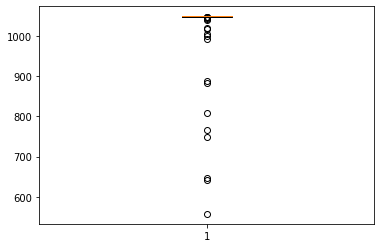

In [57]:
plt.boxplot(count[label == 1])
plt.show()

In [58]:
thresholds = [525, 700, 850, 900]
for threshold in thresholds:
    score = f1_score(target, hard_voting(train_preds, threshold=threshold), average='macro')
    print(f'{threshold}: {score:.4f}')

525: 0.9748
700: 0.9786
850: 0.9751
900: 0.9681


`-` $\frac{4}{5}$는 훈련데이터, $\frac{4}{5}$은 검증데이터

`-` 평균적으로 $n$개 예측치 중 대략 $\frac{4}{5}n$은 제대로 예측했을 것

`-` 임계치를 700, 850, 900으로 설정

`-` 훈련데이터가 80%이므로 임계치를 850, 900으로 설정하여 나온 2개의 결과물을 제출함

## 예측

In [59]:
all_test_preds = []

- LinearSVC

In [60]:
dataset = KFoldDataset(df, target, test, encoding_type='label', oversampling=False)
_, preds = seed_ensemble(trainer, linear_svc, dataset, seeds)
all_test_preds.append(preds)

Seed Ensemble Output -> Mean: 0.9607  Std: 0.0244


- LogisticRegression

In [61]:
dataset = KFoldDataset(df, target, test, encoding_type='label', oversampling=False)
_, preds = seed_ensemble(trainer, logistic, dataset, seeds)
all_test_preds.append(preds)

Seed Ensemble Output -> Mean: 0.9606  Std: 0.0235


- RidgeClassifier

In [62]:
dataset = KFoldDataset(df, target, test, encoding_type='label', oversampling=False)
_, preds = seed_ensemble(trainer, ridge, dataset, seeds)
all_test_preds.append(preds)

Seed Ensemble Output -> Mean: 0.9574  Std: 0.0241


- SGDClassifier

In [63]:
dataset = KFoldDataset(df, target, test, encoding_type='onehot', oversampling=False)
_, preds = seed_ensemble(trainer, sgd, dataset, seeds)
all_test_preds.append(preds)

Seed Ensemble Output -> Mean: 0.9553  Std: 0.0249


- XGBClassifier

In [64]:
dataset = KFoldDataset(df, target, test, encoding_type='label', oversampling=False)
_, preds = seed_ensemble(trainer, xgboost, dataset, seeds)
all_test_preds.append(preds)

Seed Ensemble Output -> Mean: 0.9567  Std: 0.0261


- CatBoostClassifier

In [65]:
dataset = KFoldDataset(df, target, test, encoding_type='label', oversampling=False)
_, preds = seed_ensemble(trainer, catboost, dataset, seeds)
all_test_preds.append(preds)

Seed Ensemble Output -> Mean: 0.9595  Std: 0.0256


- LGBMClassifier

In [66]:
dataset = KFoldDataset(df, target, test, encoding_type='label', oversampling=False)
_, preds = seed_ensemble(trainer, lgbm, dataset, seeds)
all_test_preds.append(preds)

Seed Ensemble Output -> Mean: 0.9595  Std: 0.0242


- 예측

In [67]:
test_preds = np.concatenate(all_test_preds, axis=-1)

In [69]:
preds_850 = hard_voting(test_preds, threshold=850)
preds_900 = hard_voting(test_preds, threshold=900)

In [70]:
submission['class'] = preds_850
submission['class'] = submission['class'].map({0:'A', 1:'B', 2:'C'})
submission.to_csv('./data/submission-850.csv', index=False)  

In [71]:
submission['class'] = preds_900
submission['class'] = submission['class'].map({0:'A', 1:'B', 2:'C'})
submission.to_csv('./data/submission-900.csv', index=False)  